In [171]:
r"""
- compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
- alternately, one could use unitary representations and normalization factors \sqrt{d_\rho/|G|}
- the resulting DFT will have signs \pm 1 on the diagonal DFT.DFT^* = S, which can be factored as s = rr^*, so S=RR^*
- uDFT = R^{-1}.DFT"
""";

In [172]:
r"""
notes: 
    - F = GF(q**2), K = field containing all eigenvalues, L = splitting field of charpoly_F
    - Gal(K/F) is relative Galois group, and F fixes coefficients of charpoly
    - size of orbits should divide |Gal(K/F)| and add up to n
    - if K = GF(q**m), then |Gal(K/F)| = m/2
    - for n=4, q=7: K = GF(7**30), L = GF(7**210). so m=30 or m=210, therefore 
    - looks like charpoly is degree 24, and factoring over F into irreducibles of degree 1+1+7+15
    - this suggest we really need to be working over the splitting field L = GF(q**210) since `7|105` but `7 \nmid 15`
    - over L, the sizes of Galois orbits are {1,15}
    - over L, the sizes of Galois orbits are {1,7,15}
    - the equivalence classes over L capture all possible Galois orbits (including of size 7)
    - we need to work over the splitting field, even though the degree is large
    - for `n=4`, `q=7`:
        - splitting field degree = 210
        - (deg, mult.) of charpoly_F factors = [(1,1),(1,1),(7,1),(15,1)]
    - for `n=5`, `q=7`
        - splitting field degree = 418
        - (deg, mult.) of charpoly_F factors= [(22,1),(22,1),(38,1),(38,1)]
    - for `n=5`, `q=13`
        - splitting field degree = 14352
        - (deg, mult.) of charpoly_F factors = [(3, 1), (3, 1), (8, 1), (8, 1), (13, 1), (23, 1), (23, 1), (39, 1)]
    - for `n=5`, `q=11`
        - splitting field degree = 39900
        - (deg, mult.) of charpoly_F factors = [(1,1),(2,1),(2,1),(19,1),(21,1),(75,1)]
    - for `n=5`, `q=17`
        - splitting field degree = 325130
        - (deg, mult.) of charpoly_F factors = [(5,1), (13,1), (41,1), (61,1)]
""";

In [173]:
from utils.field_utils import conj_sqrt, discrete_log, brauer_map, round_complex, alpha, galois_orbit, galois_orbit_equiv_classes
from utils.io_utils import load_csv_as_matrix, write_matrix_to_csv, save_array, load_array, str_repn_to_alg_closure
from utils.plot_utils import plot_discrete_log, plot_arg_complex, plot_complexified_eigenvalues

In [174]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
def unitary_dft(SGA):
    dft_matrix = SGA.dft()
    sign_diag = (dft_matrix*dft_matrix.H).diagonal()
    factor_diag_inv = diagonal_matrix([~conj_sqrt(d) for d in sign_diag])
    return factor_diag_inv*dft_matrix

In [175]:
#parameters and define the symmetric group algebra
n = 3; q = 7
F = GF(q**2)
SGA = SymmetricGroupAlgebra(F,n) # F[S_n], group algebra
assert F.characteristic() > 0, "F must have positive characteristic"
if not (F.is_field() and F.is_finite() and F.order().is_square()):
    raise ValueError("the base ring must be a finite field of square order")
if F.characteristic().divides(SGA.group().cardinality()):
    raise NotImplementedError("not implemented when p|n!; dimension of invariant forms may be greater than one")

In [176]:
#converting the unitary DFT over finite fields to a complex matrix using the root of unity map
U = unitary_dft(SGA)

In [177]:
#check that U is unitary over a finite field. .H is conjugate-transpose
U*U.H == 1

True

In [178]:
#compute the discrete log of each entry of U
dlog_U = U.apply_map(lambda x: discrete_log(F,x))

In [179]:
dlog_U

[45 45 45 45 45 45]
[47 31 23  7  7 31]
[-1 20 -1 20 44 44]
[-1 44 -1 20 44 20]
[47  7 47  7  7  7]
[45 21 21 45 45 21]

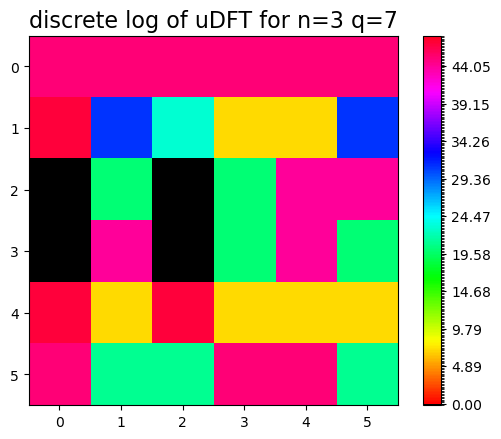

In [180]:
plot_discrete_log(F,dlog_U,path='plots/dft_matrix/',title=f"discrete log of uDFT for n={n} q={q}",normalize=None)

In [181]:
#complexify the uDFT matrix over F_q using the Brauer map
U_complex = matrix(CC,U.apply_map(lambda a: brauer_map(F,a)))

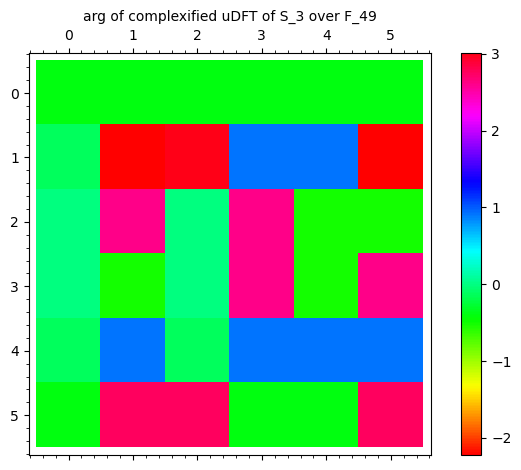

In [182]:
#plot the complexified version of the uDFT matrix over a finite field
plot_arg_complex(U_complex,title=f"arg of complexified uDFT of S_{n} over F_{q**2}")

In [183]:
#compute the Gram matrix, taking inner products of rows and columns w.r.t conjugate inner product
#note: want this to be the identity matrix (so it would be unitary over \C), but currently it is not quite
gram = U_complex*U_complex.H

In [184]:
#check that Gram matrix is conjugate symmetric (should be since it is U*U.H)
gram == gram.H

True

In [185]:
#round the (complex) Gram matrix to three decimal places
gram_rounded = gram.apply_map(lambda u:round_complex(u,3))

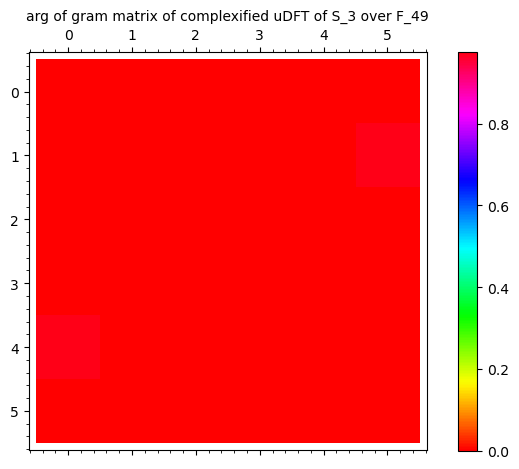

In [186]:
#plot the result of U_complex*U_complex.H to see how far it is from being unitary over the complex numbers
plot_arg_complex(gram_rounded, title=f"arg of gram matrix of complexified uDFT of S_{n} over F_{q**2}")

In [187]:
#load or compute+save the eigenvalues of the uDFT matrix over the algebraic closure of F
path = 'data/eigenvalues'
filename = f"eigenvalues_uDFT_n={n}_q={q}_deg=infty" + '.csv'
if os.path.exists(os.path.join(path, filename)):
    F_bar = F.algebraic_closure()
    eigenvalues_F_bar_list = load_array(path,filename)
    eigenvalues_F_bar = str_repn_to_alg_closure(F_bar, eigenvalues_F_bar_list)
else:
    eigenvalues_F_bar = U.eigenvalues()
    save_array(eigenvalues_F_bar, path=path, filename=filename)

In [188]:
#compute the maximum degree required for the eigenvalues
#issue: why does this not match the degree of the splitting field?
max_deg_eigs = max([eig.minpoly().degree() for eig in eigenvalues_F_bar]);
K = GF(q**max_deg_eigs); print(f"field containing all eigenvalues: K = {K}")

field containing all eigenvalues: K = Finite Field in z2 of size 7^2


In [189]:
#compute the multiplicity of each eigenvalue. check if all eigenvalues are distinct
from collections import Counter
multiplicities = Counter(eigenvalues_F_bar)
all_unique = all(count == 1 for count in multiplicities.values()); all_unique

False

In [190]:
#compute the charpoly of the uDFT matrix 
charpoly_F = U.charpoly(); print("charpoly_F: ",charpoly_F)

charpoly_F:  x^6 + (3*z2 + 2)*x^5 + (2*z2 + 5)*x^4 + x^3 + 5*z2*x^2 + (4*z2 + 5)*x + 1


In [191]:
#factor the characteristic polynomial over the base field GF(q**2) into irreducibles
charpoly_F_factor = charpoly_F.factor(); charpoly_F_factor

(x + 5*z2 + 6) * (x + 2*z2 + 4)^2 * (x + 5*z2 + 3)^3

In [192]:
#compute the degree, multiplicity of each irreducible factor of the charpoly over F
charpoly_F_deg_mult = [(poly[0].degree(), poly[1]) for poly in charpoly_F_factor]; charpoly_F_deg_mult

[(1, 1), (1, 2), (1, 3)]

In [193]:
#compute the splitting field degree by just taking the lcm of the degrees of the irreducible factors
#note: much faster than .splitting_field as finite fields are classified by degree
splitting_field_deg = 2*lcm(item[0] for item in charpoly_F_deg_mult); splitting_field_deg

2

In [194]:
#compute a splitting field of the characteristic polynomial directly
L = charpoly_F.splitting_field('a'); L

Finite Field in a of size 7^2

In [195]:
assert splitting_field_deg == L.degree(), "splitting field degree should match the lcm of the degrees of the irreducible factors"

In [196]:
#load or compute+save the eigenvalues over L
path = 'data/eigenvalues'
filename = f"eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv'
if os.path.exists(os.path.join(path, filename)):
    eigenvalues_list = load_array(path,filename)
    eigenvalues_L = [L(x) for x in eigenvalues_list]
else:
    eigenvalues_L = matrix(L,U).eigenvalues(extend=False)
    save_array(eigenvalues_L, path=path, filename=filename)

In [197]:
#load or compute+save the discrete log (dlog) of the eigenvalues over L
path='data/discrete_log_eigenvalues'
filename=f"discrete_log_eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv'
if os.path.exists(os.path.join(path, filename)):
    dlog_eigenvalues_list = load_array(path,filename)
    dlog_eigenvalues_L = [int(x) for x in dlog_eigenvalues_list]
else:
    dlog_eigenvalues_L = list(map(lambda x: discrete_log(L,x), eigenvalues_L))
    save_array(dlog_eigenvalues_L, path=path, filename=filename)

In [198]:
#compute and save the complexified eigenvalues over L
#NOTE: use precomputed dlog values for the Brauer map to avoid recomputing them
path='data/complexified_eigenvalues'
filename=f"complexified_eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv'
complexified_eigenvalues_L = [brauer_map(L,log_a=log_eig) for log_eig in dlog_eigenvalues_L]
save_array(complexified_eigenvalues_L, path=path, filename=filename)

In [199]:
#compute Galois orbit sizes for each eigenvalue in L
galois_orbit_size_L = [len(galois_orbit(alpha,F,eig)) for eig in eigenvalues_L]; print(galois_orbit_size_L)

[1, 1, 1, 1, 1, 1]


In [200]:
#compute the equivalence classes of orbits under the Galois action on eigenvalues over L, the splitting field
galois_orbit_classes_L = galois_orbit_equiv_classes(alpha, F, eigenvalues_L)
#compute size of Galois orbit classes for eigenvalues_L
galois_orbit_class_sizes_L = [len(galois_orbit_classes_L[key]) for key in galois_orbit_classes_L]; print(galois_orbit_class_sizes_L)

[1, 1, 1]


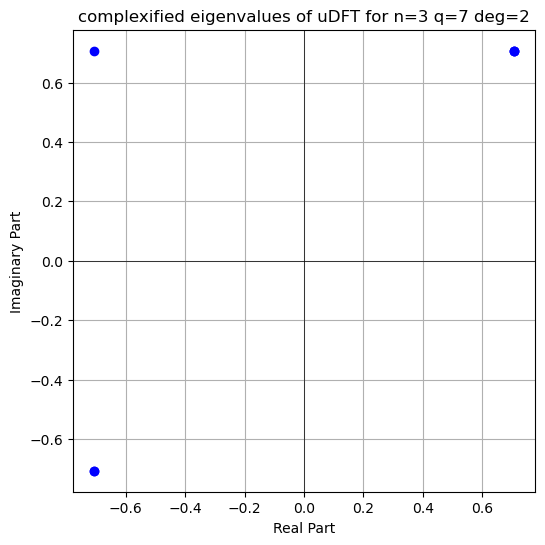

In [201]:
#plot the eigenvalues on the unit circle in the complex plane after applying the Brauer map
plot_complexified_eigenvalues(complexified_eigenvalues_L, n, q, L)

In [202]:
#compute the eigenvectors over a splitting field
D, P = matrix(L,U).eigenmatrix_right()

In [203]:
write_matrix_to_csv(P,filename=f"data/eigenvectors/eigenvectors_unitary_dft_symmetric_group_finite_field_n={n}_q={q}.csv")

In [204]:
#take the discrete log of the eigenvector matrix
path = 'data/discrete_log_eigenvector_matrix'
filename = f"discrete_log_dft_symmetric_group_finite_field_eigenvector_matrix_n={n}_q={q}.csv"
full_path = os.path.join(path, filename)
if os.path.exists(full_path):
    dlog_P = load_csv_as_matrix(full_path)
else:
    dlog_P = P.apply_map(lambda x: discrete_log(L,x)); dlog_P

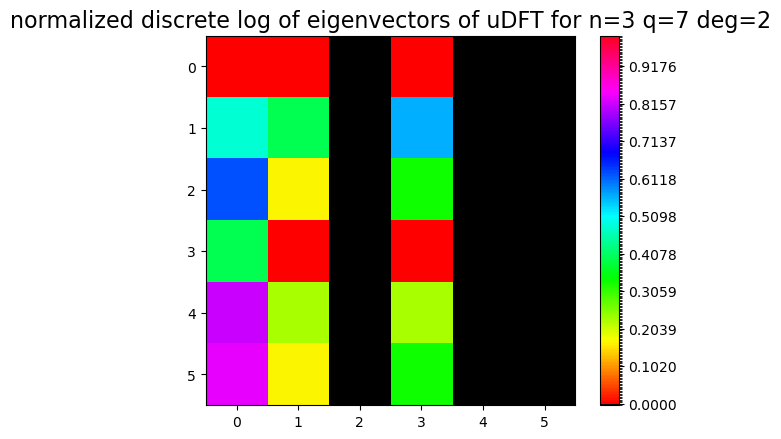

In [205]:
#plot the discrete log of the eigenvector matrix P
#NOTE: the `normalize` parameter is required for n=4 or above
plot_discrete_log(L,dlog_P,path='plots/eigenvectors/',title=f"normalized discrete log of eigenvectors of uDFT for n={n} q={q} deg={L.degree()}",normalize="rescale")

In [206]:
def compute_save_dlog_eigenvector_matrix(L, P, path, filename):
    """
    - compute the discrete log of each entry of P, the eigenvector matrix of the uDFT of S_n over F_{q^2}
    - write the resulting matrix to a comma separated value file
    - include a progress bar since computing discrete logs for large fields takes a long time
    """
    total = P.nrows() * P.ncols()
    count = 0
    full_path = os.path.join(path,filename)
    with open(full_path, "w") as f:
        for i in range(P.nrows()):
            for j in range(P.ncols()):
                log_value = discrete_log(L, P[i, j])
                f.write(str(log_value))
                if j != P.ncols()-1:
                    f.write(",")
                count += 1
                # Print progress as a percentage
                progress = float(count) / total * 100
                print(f"Progress: {progress:.2f}%\n", end="\r", flush=True)
            f.write("\n")
    return "done"

In [207]:
path = "data/eigenvectors"
filename = f"discrete_log_dft_symmetric_group_finite_field_eigenvector_matrix_n={n}_q={q}.csv"
compute_save_dlog_eigenvector_matrix(L, P, path=path, filename=filename)

Progress: 2.78%
Progress: 5.56%
Progress: 8.33%
Progress: 11.11%
Progress: 13.89%
Progress: 16.67%
Progress: 19.44%
Progress: 22.22%
Progress: 25.00%
Progress: 27.78%
Progress: 30.56%
Progress: 33.33%
Progress: 36.11%
Progress: 38.89%
Progress: 41.67%
Progress: 44.44%
Progress: 47.22%
Progress: 50.00%
Progress: 52.78%
Progress: 55.56%
Progress: 58.33%
Progress: 61.11%
Progress: 63.89%
Progress: 66.67%
Progress: 69.44%
Progress: 72.22%
Progress: 75.00%
Progress: 77.78%
Progress: 80.56%
Progress: 83.33%
Progress: 86.11%
Progress: 88.89%
Progress: 91.67%
Progress: 94.44%
Progress: 97.22%
Progress: 100.00%


'done'